In [26]:
# Value class starter code, with many functions taken out

import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"


  def __truediv__(self, other): # self / other
    return self * (other ** -1)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
      
  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __sub__(self, other): # self - other
    return self + (-other)

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out
      
  
  def exp(self):
      out = Value(math.exp(self.data), (self,), 'exp')

      def _backward():
          self.grad += out.data * out.grad
      out._backward = _backward
      return out

 
  def log(self):
    # Forward pass
    import math  # or from math import log at the top, then just call log(...)
    out = Value(math.log(self.data), (self,), 'log')
    
    def _backward():
        # derivative of log(x) wrt x is 1/x
        self.grad += (1.0 / self.data) * out.grad
    
    out._backward = _backward
    return out 

    
  def __neg__(self):
    out = Value(-self.data, (self,), 'neg')

    def _backward():
        self.grad += -out.grad  # derivative of -x is -1
    out._backward = _backward
    return out  


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out
       
  def backward(self): # exactly as in video  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

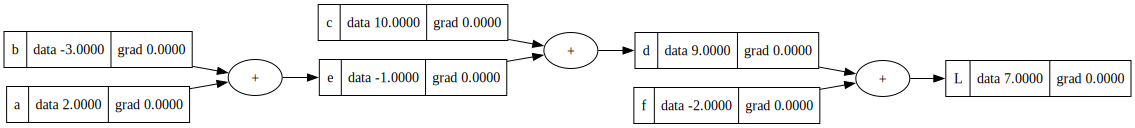

In [6]:
draw_dot(L)

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=7.0)

In [30]:
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = counts[0]
  for c in counts[1:]:
    denominator = denominator + c
  print(denominator)
  print(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example

Value(data=23.939154034883327)
[Value(data=1.0), Value(data=20.085536923187668), Value(data=0.1353352832366127), Value(data=2.718281828459045)]


In [31]:
loss

Value(data=2.1755153626167147)

In [32]:
probs

[Value(data=0.04177257051535045),
 Value(data=0.839024507462532),
 Value(data=0.00565330266221633),
 Value(data=0.11354961935990122)]

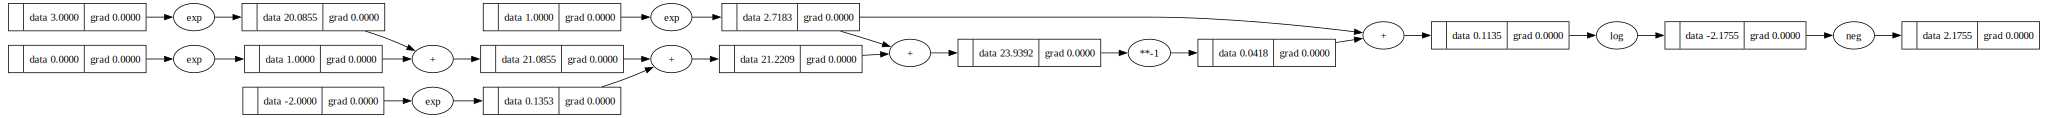

In [33]:
draw_dot(loss)

In [34]:
loss.backward()

In [35]:
loss

Value(data=2.1755153626167147)

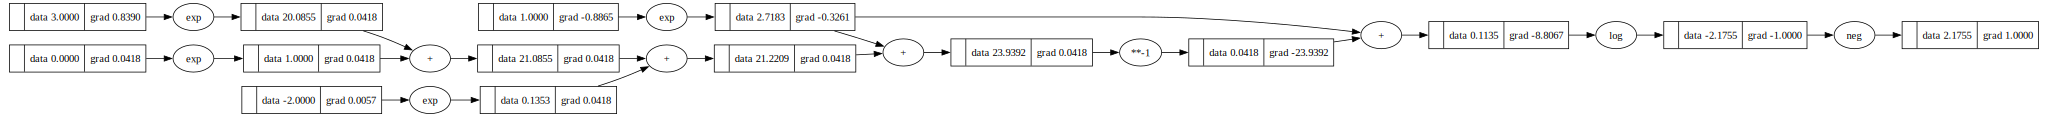

In [36]:
draw_dot(loss)

In [37]:
ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


In [2]:
import torch

# Logits as torch tensors with requires_grad=True for gradient tracking
logits = torch.tensor([0.0, 3.0, -2.0, 1.0], requires_grad=True)

# Softmax function using PyTorch
probs = torch.softmax(logits, dim=0)

# Negative log-likelihood loss for class 3 (index 3 is the true label)
loss = -torch.log(probs[3])

# Backpropagate to compute gradients
loss.backward()

# Log gradients of logits and loss value
print("Loss:", loss.item())
print("Gradients of logits:", logits.grad)

/Users/lessandro/Interview/virtualenv/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:275: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


Loss: 2.1755154132843018
Gradients of logits: tensor([ 0.0418,  0.8390,  0.0057, -0.8865])


In [1]:
2+2

4

In [4]:
import random

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [47]:
n1 = Neuron(2)

In [51]:
x = [2.0, 3.0]

In [49]:
print(n1(x))

Value(data=-0.5525610770401491)


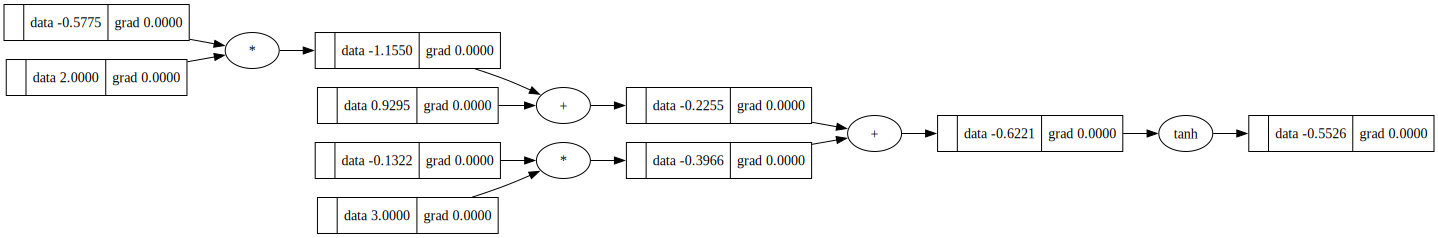

In [52]:
draw_dot(n1(x))

In [63]:
n1x = n1(x)

In [64]:
n1x.backward()

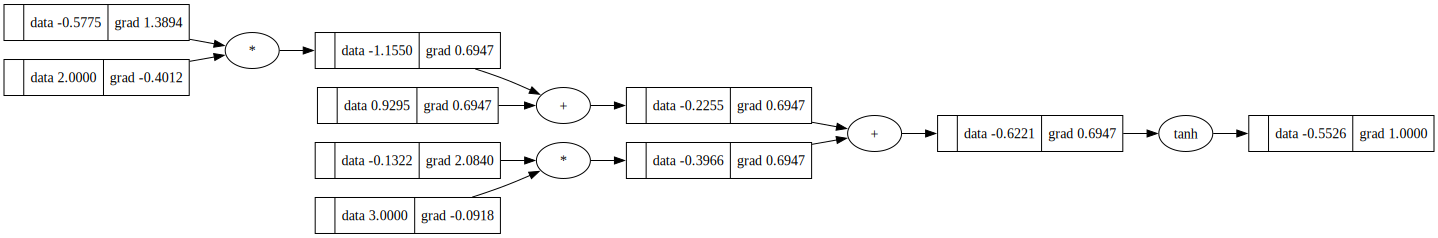

In [65]:
draw_dot(n1x)

In [59]:
l1 = Layer(2, 2)

In [60]:
l2 = Layer(2, 1)

In [61]:
l2(l1(x))

Value(data=-0.9184652213251748)

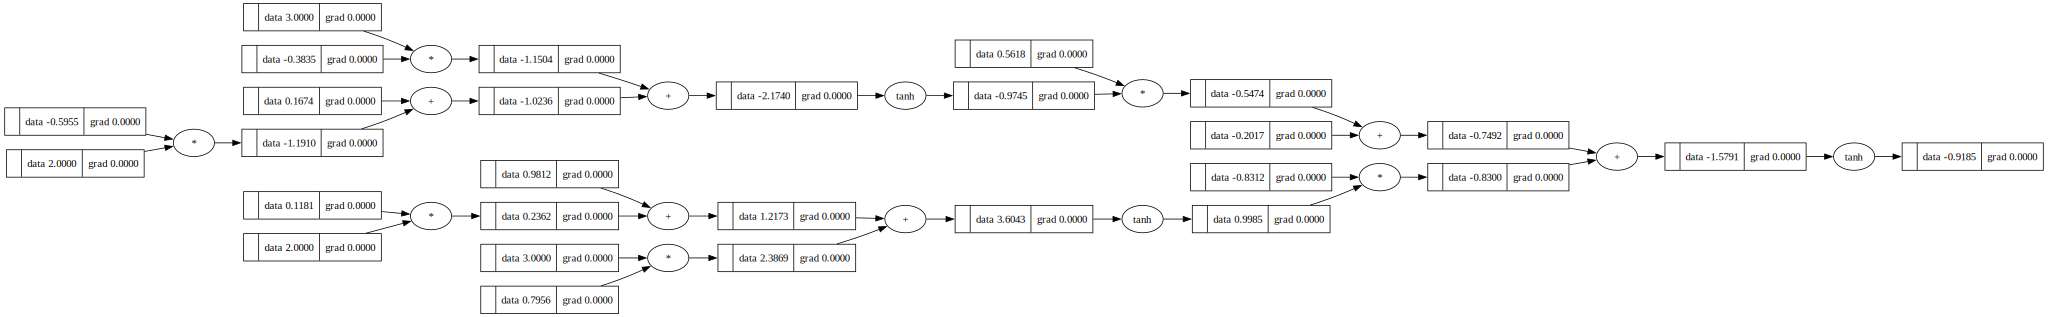

In [62]:
draw_dot(l2(l1(x)))

In [66]:
x

[2.0, 3.0]

In [68]:
m = MLP(2, [2, 1])

In [69]:
m(x)

Value(data=0.31081574112930094)

In [73]:
MX = m(x)

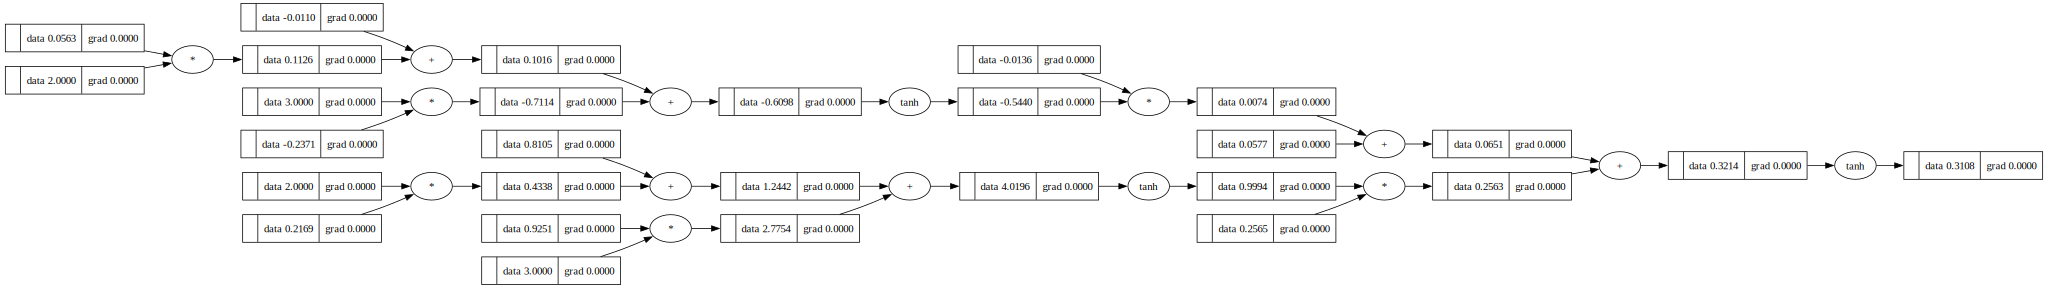

In [74]:
draw_dot(MX)

In [75]:
MX.backward()

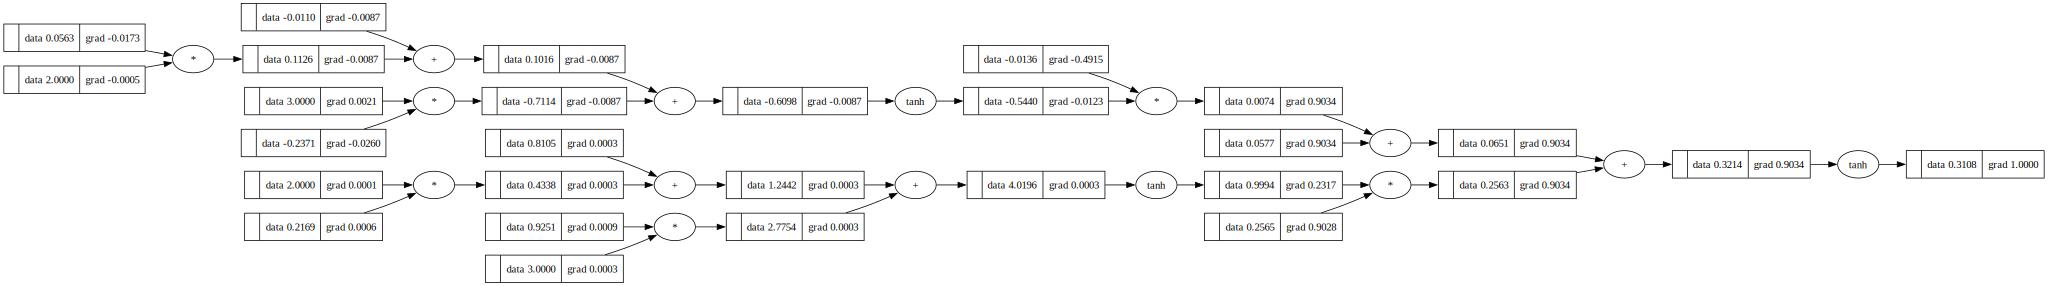

In [77]:
draw_dot(MX)

In [68]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [72]:
m = MLP(3, [3,4,4,1])

In [73]:
for k in range(30):
    print("epoch "+str(k))
    pred = [m(x) for x in xs]
    loss = [(pred - ys)**2  for pred,ys in zip(pred, ys)]

    overall_loss = 0
    for l in loss:
        overall_loss += l.data
    overall_loss /= len(loss)
    print(overall_loss)

    for l in loss:
        l.backward()

    for p in m.parameters():
        p.data -= 0.01 * p.grad

epoch 0
1.0467279475773639
epoch 1
1.028312696928712
epoch 2
1.000728032237339
epoch 3
0.9739883864083827
epoch 4
0.9494326529374775
epoch 5
0.9209074028954383
epoch 6
0.8845825790484688
epoch 7
0.8435197746108845
epoch 8
0.8010859424864321
epoch 9
0.7534284694142455
epoch 10
0.6947728991120103
epoch 11
0.6301693887832709
epoch 12
0.572825015096958
epoch 13
0.5192949362368358
epoch 14
0.4282669082625997
epoch 15
0.2322110105944168
epoch 16
0.08863362745612041
epoch 17
0.05138097669367828
epoch 18
0.024386237300048873
epoch 19
0.00960279015726144
epoch 20
0.003531786288130145
epoch 21
0.001316733980390757
epoch 22
0.0005191481428681524
epoch 23
0.0002200184827405545
epoch 24
0.00010030659936989214
epoch 25
4.8831094946720605e-05
epoch 26
2.5118321055406448e-05
epoch 27
1.3506307874338839e-05
epoch 28
7.518842602867141e-06
epoch 29
4.298808012758368e-06


1.4729052765820796